# CartPole-v1

# Import Dependencies

In [ ]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import gym
from torch.autograd import Variable
import random

# Define Parameters

In [ ]:
LR = 0.01
GAMMA = 0.99

# Creating an environment in OpenAI Gym

In [ ]:
env = gym.make('CartPole-v0').unwrapped
history = []

# Setting up the policy network

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
        self.l1 = nn.Linear(4, 150)
        self.l2 = nn.Linear(150, 2)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x

In [ ]:
model = Network()

use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor

optim = torch.optim.Adam(model.parameters(), lr=LR)

# Training

In [ ]:
def calculate_discount_rewards(r):
    discounted_r = torch.zeros(r.size())
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * GAMMA + r[t]
        discounted_r[t] = running_add

    return discounted_r

In [ ]:
def run_episode(net, e, env):
    state = env.reset()
    reward_sum = 0
    xs = FloatTensor([])
    ys = FloatTensor([])
    rewards = FloatTensor([])
    steps = 0

    while True:
        x = FloatTensor([state])
        xs = torch.cat([xs, x])

        action_prob = net(Variable(x))

        # select an action depends on probability
        action = 0 if random.random() < action_prob.data[0][0] else 1

        y = FloatTensor([[1, 0]] if action == 0 else [[0, 1]])
        ys = torch.cat([ys, y])

        state, reward, done, _ = env.step(action)
        rewards = torch.cat([rewards, FloatTensor([[reward]])])
        reward_sum += reward
        steps += 1

        if done or steps >= 500:
            adv = calculate_discount_rewards(rewards)
            adv = (adv - adv.mean())/(adv.std() + 1e-7)
            loss = learn(xs, ys, adv)
            history.append(reward_sum)
            print("[Episode {:>5}] reward: {}".format(e, reward_sum))
            if sum(history[-5:])/5 > 490:
                return True
            else:
                return False

In [ ]:
def learn(x, y, adv):
    # calculate probabilities of taking each action
    action_pred = model(Variable(x))
    y = Variable(y, requires_grad=True)
    adv = Variable(adv).cuda()
    log_lik = -y * torch.log(action_pred)
    log_lik_adv = log_lik * adv
    loss = torch.sum(log_lik_adv, 1).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.data

In [ ]:
for e in range(10000):
    complete = run_episode(model, e, env)
    
    if complete:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


[Episode     0] reward: 12.0
[Episode     1] reward: 14.0
[Episode     2] reward: 31.0
[Episode     3] reward: 42.0
[Episode     4] reward: 33.0
[Episode     5] reward: 25.0
[Episode     6] reward: 27.0
[Episode     7] reward: 25.0
[Episode     8] reward: 33.0
[Episode     9] reward: 36.0
[Episode    10] reward: 75.0
[Episode    11] reward: 50.0
[Episode    12] reward: 39.0
[Episode    13] reward: 73.0
[Episode    14] reward: 31.0
[Episode    15] reward: 28.0
[Episode    16] reward: 53.0
[Episode    17] reward: 83.0
[Episode    18] reward: 100.0
[Episode    19] reward: 41.0
[Episode    20] reward: 103.0
[Episode    21] reward: 169.0
[Episode    22] reward: 159.0
[Episode    23] reward: 56.0
[Episode    24] reward: 76.0
[Episode    25] reward: 108.0
[Episode    26] reward: 34.0
[Episode    27] reward: 81.0
[Episode    28] reward: 86.0
[Episode    29] reward: 272.0
[Episode    30] reward: 68.0
[Episode    31] reward: 99.0
[Episode    32] reward: 47.0
[Episode    33] reward: 218.0
[Episod

# Plotting average reward per episode

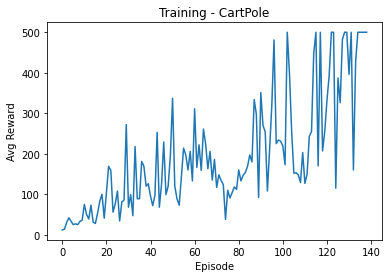

In [ ]:
import matplotlib.pyplot as plt

plt.figure(2)
plt.clf()
plt.title('Training - CartPole')
plt.xlabel('Episode')
plt.ylabel('Avg Reward')
plt.plot(history)